In [137]:
import matplotlib.pyplot as plt
from skimage.filters import gaussian, sobel, sobel_h, sobel_v
from skimage.morphology import skeletonize
import numpy as np

In [139]:
# im = plt.imread('calibration_left.jpg')[:,:,0]
im = plt.imread('baby.png')[:,:,0]

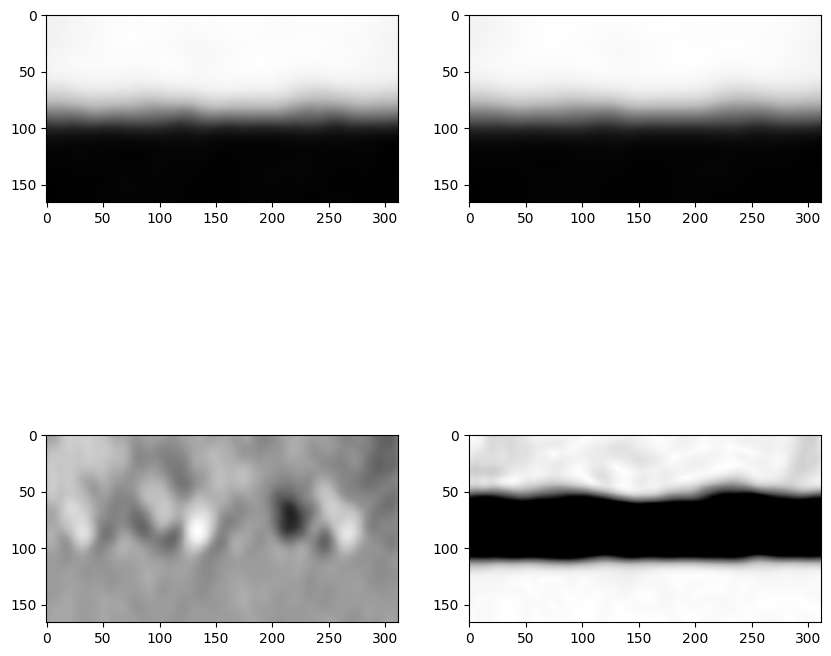

In [140]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(im,cmap='Greys')
plt.subplot(2,2,2)
im_blur = gaussian(im,sigma=5)
plt.imshow(im_blur,cmap='Greys')
plt.subplot(2,2,3)
plt.imshow(sobel_v(im_blur)*100,vmax=1,cmap='Greys')
plt.subplot(2,2,4)
plt.imshow(sobel(im_blur)*100,vmax=1,cmap='Greys')

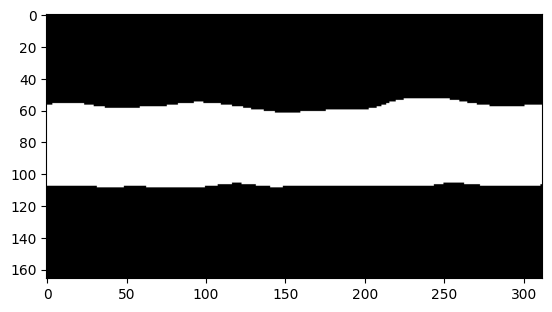

In [141]:
from skimage.morphology import skeletonize

im_sobel = sobel(im_blur)
thresholded = im_sobel < 0.01
# thresholded = 255 - thresholded
# skeleton = skeletonize(thresholded)
plt.imshow(thresholded,cmap='Greys')

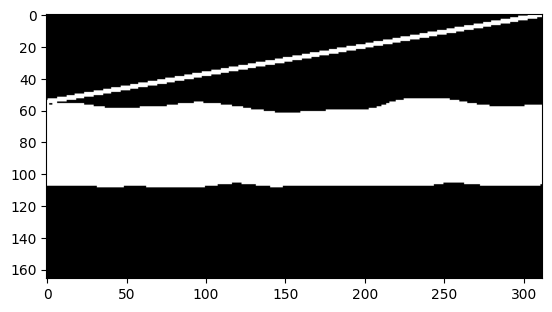

In [143]:
thresholded =thresholded.astype(np.uint8)

lines = cv2.HoughLines(thresholded, 1, np.pi / 180, 1, None, 0, 0)

for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(thresholded,(x1,y1),(x2,y2),(0,0,155),2)
plt.imshow(thresholded,cmap='Greys')


30460